# Predicting bike rental numbers using machine learning
## Introduction
The goal of this project is to predict how many bikes are rented from a bike sharing service at each hour. The dataset used to build the machine learning model provides the time and weather conditions along with the number of bikes rented.

The data file used in this project can be downloaded [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Steps:
* The correlation between data set columns is explored to identify good candidate features and remove colinear ones
* An additional feature indicating the time of day (morning, afternoon, etc.) is generated
* Linear regression, decision tree and random forest algorithms are applied 

The random forest algorithm is found to perform with the lowest RMS error

## Preparing the data
### Reading and exploring the data

In [121]:
import pandas as pd
bike_rentals = pd.read_csv('bike_rental_hour.csv')
print(bike_rentals.head(3), '\n')
print(bike_rentals.info())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
working

* The target column will be 'cnt', which indicates the total number of bikes rented at each hour.
* 'registered' and 'casual' are just the total number of rentals split between the type of user, these columns are redundant
* The data is already in numerical form, except for dteday, and there are no missing values
* the 'instant' column is just a unique identifier

In [122]:
features = bike_rentals.columns.tolist()
# removing target and redundant features from list
features.remove('cnt')
features.remove('casual')
features.remove('registered')
features.remove('instant')
features.remove('dteday')

### Visualizing bike rental totals
Let's see how the value we are trying to predict is distributed

Text(0.5, 0, 'Total Bike Rentals')

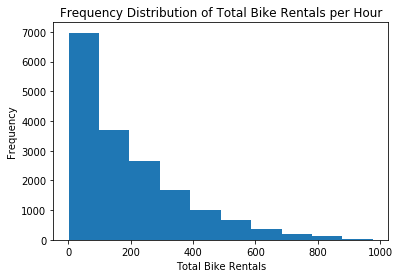

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline
# plotting total bike rental counts as a histogram
bike_rentals['cnt'].plot.hist()
plt.title('Frequency Distribution of Total Bike Rentals per Hour')
plt.xlabel('Total Bike Rentals')

From this frequency distribution, we should keep in mind that the error might be large for our models, as some hours have hundreds of bike rentals, while many have near zero.

### Identifying useful features
* We can identify and remove redundant features by calculating their correlation
* The usefulness of the remaining features can be ranked by their correlation to our target

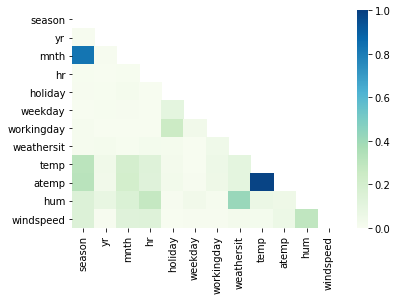

In [124]:
import seaborn as sns
import numpy as np
# plotting the correlation between all features
corr = bike_rentals[features].corr().abs()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap='GnBu')

* Month and season columns are strongly correlated, as expected. We can keep the month column as it has finer definition (12 vs 4)
* temp and atemp provide the same information, let's keep atemp

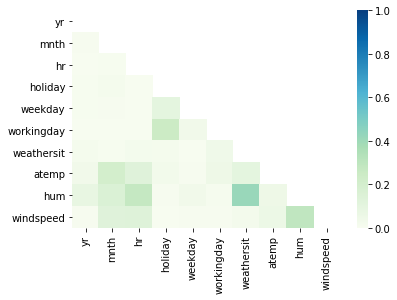

In [125]:
# removing colinear features
features.remove('season')
features.remove('temp')
# plotting the correlation between all remaining features
corr = bike_rentals[features].corr().abs()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap='GnBu')

In [136]:
# printing the correlation between remaining features and our target
bike_rentals.corr()['cnt'].abs().reindex(features).sort_values(ascending=False)

atemp         0.400929
hr            0.394071
time_label    0.378318
hum           0.322911
yr            0.250495
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

Although some features such as weekday have a low correlation, removing them is not necessary, since the number of total features is still quite small and the models will converge quickly.

### Creating an additional feature
We can increase the model's knowledge by grouping hours by time of day, linking closer hours together.

In [137]:
# function to perform the labelling
def assign_label(hour):
    if (hour>=6 and hour<12):
        return 1
    elif (hour>=12 and hour<18):
        return 2
    elif (hour>=18 and hour<24):
        return 3
    else:
        return 4

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
features.append('time_label')
print(bike_rentals.head(3))

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  \
0           1  0.24  0.2879  0.81        0.0       3          13   16   
1           1  0.22  0.2727  0.80        0.0       8          32   40   
2           1  0.22  0.2727  0.80        0.0       5          27   32   

   time_label  
0           4  
1           4  
2           4  


Now that all our features are ready, it is time to fit the data to various models.

## Fitting machine learning models
### Dividing into training and testing sets
Lets separate our data into training and testing sets. The random seed is fixed for reproducibility.

In [128]:
train = bike_rentals.sample(int(len(bike_rentals)*.8), random_state=13)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

### Linear Regression model
Let's first test the simplest model, linear regression. The error metric will be the root mean squared error.

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
target = 'cnt'
model.fit(train[features], train[target])
predictions = model.predict(test[features])
rmse = mean_squared_error(predictions, test[target])**.5
rmse

129.39071104172422

Since the error is quite large (around 130 bikes per hour), it is logical to try different models. Next, let's apply the decision tree algorithm.
### Decision Tree Model

In [130]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(train[features], train[target])
predictions = model.predict(test[features])
rmse = mean_squared_error(predictions, test[target])**.5
rmse

62.76199746392462

The error was reduced by half! We can further improve on this model by setting a minimum number of elements in each leaf, thus reducing oversampling and therefore obtaining better results on our testing set.

In [131]:
model = DecisionTreeRegressor(min_samples_leaf=5)
model.fit(train[features], train[target])
predictions = model.predict(test[features])
rmse = mean_squared_error(predictions, test[target])**.5
rmse

55.887406182889976

The logical extension to a decision tree is to apply a random forest, reducing overfitting even further by using randomness in the choice of feature to split on at each branch.
### Random Forest model

In [132]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(min_samples_leaf=5)
model.fit(train[features], train[target])
predictions = model.predict(test[features])
rmse = mean_squared_error(predictions, test[target])**.5
rmse

C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


49.88805201866304

## Conclusion
The random forest model provided the lowest RMS error, at around 50 bikes. Considering the distribution of the data plotted earlier, this is a great result.